# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [2]:
df = pd.read_csv('../data/epa_final.csv')

In [3]:
df = df[df['PM2.5 Monthly Mean'] > 0]

In [4]:
df.head()

,Date Local,Latitude,Longitude,PM2.5 Monthly Mean,lat_2dec,lon_2dec,no2,aod,temp,precip
0,2019-01-31,30.497478,-87.880258,6.825000,30.5,-87.88,1.541665e+15,0.052667,290.88,3.993249
1,2019-01-31,38.013333,-87.577222,9.860000,30.5,-87.88,1.120693e+15,0.035250,290.56,4.091899
2,2019-01-31,41.874999,-90.177574,10.290000,30.5,-87.88,1.374970e+15,0.201500,288.74,4.167067
3,2019-01-31,38.013333,-87.577222,7.222581,30.5,-87.88,1.120693e+15,0.035250,290.56,4.091899
4,2019-01-31,41.164400,-81.235200,8.762500,30.5,-87.88,1.421505e+15,0.035250,290.56,4.091899


In [5]:
df.shape

(13828, 10)

In [6]:
df.isnull().sum()

Date Local            0
Latitude              0
Longitude             0
PM2.5 Monthly Mean    0
lat_2dec              0
lon_2dec              0
no2                   0
aod                   0
temp                  0
precip                0
dtype: int64

# X, y, train_test_split

In [7]:
X = df.drop(columns = ['Date Local', 'PM2.5 Monthly Mean', 'lat_2dec', 'lon_2dec'])
y = df['PM2.5 Monthly Mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [8]:
y.mean()

7.442811142453138

## StandardScaler X_train and X_test for testing

In [9]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Polynomial X_train and X_test for testing

In [10]:
poly = PolynomialFeatures()
X_train_sc_p = poly.fit_transform(X_train_sc)
X_test_sc_p = poly.fit_transform(X_test_sc)

# Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
print(f'Linear Regression Train Score: {lr.score(X_train_sc, y_train)}')
print(f'Linear Regression Test Score: {lr.score(X_test_sc, y_test)}')

Linear Regression Train Score: 0.07680778549291478
Linear Regression Test Score: 0.0821680892657426


In [12]:
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('lr', LinearRegression())
])

lr_pipe.fit(X_train, y_train)
print(f'LR Pipe Train Score: {lr_pipe.score(X_train, y_train)}')
print(f'LR Pipe Test Score: {lr_pipe.score(X_test, y_test)}')

LR Pipe Train Score: 0.2034940109003135
LR Pipe Test Score: 0.19706446999268568


## AdaBoost with Linear Regression

In [13]:
ada_lr = AdaBoostRegressor(base_estimator = LinearRegression(), random_state = 42)

ada_lr.fit(X_train_sc, y_train)
print(f'Ada LR Train Score: {ada_lr.score(X_train_sc, y_train)}')
print(f'Ada LR Test Score: {ada_lr.score(X_test_sc, y_test)}')

Ada LR Train Score: 0.0626114218651278
Ada LR Test Score: 0.07399082698682935


# Trees Models

## Decision Tree on Scaled Features

In [14]:
dt_sc = DecisionTreeRegressor()
dt_sc.fit(X_train_sc, y_train)
print(f'DT Scaled Train Score: {dt_sc.score(X_train_sc, y_train)}')
print(f'DT Scaled Test Score: {dt_sc.score(X_test_sc, y_test)}')

DT Scaled Train Score: 0.9650650500696505
DT Scaled Test Score: 0.5392625061475895


## Decision Tree on Polynomial Features

In [15]:
dt_p = DecisionTreeRegressor()
dt_p.fit(X_train_sc_p, y_train)
print(f'DT Polynomial Train Score: {dt_p.score(X_train_sc_p, y_train)}')
print(f'DT Polynomial Test Score: {dt_p.score(X_test_sc_p, y_test)}')

DT Polynomial Train Score: 0.9650650500696505
DT Polynomial Test Score: 0.43236093758563565


## AdaBoost with Decision Tree Base Estimator

In [16]:
ada_dt = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), random_state = 42)

ada_dt_params = {
    'n_estimators': [50, 100, 150, 200],
    'base_estimator__max_depth': [1, 2, 5]
}

gs_ad_dt = GridSearchCV(ada_dt, param_grid = ada_dt_params, cv = 5)
gs_ad_dt.fit(X_train_sc, y_train)
print(gs_ad_dt.best_score_)
print(gs_ad_dt.best_params_)
print(f'Ada DT Train Score: {gs_ad_dt.score(X_train_sc, y_train)}')
print(f'Ada DT Test Score: {gs_ad_dt.score(X_test_sc, y_test)}')

0.3082496636438291
{'base_estimator__max_depth': 5, 'n_estimators': 50}
Ada DT Train Score: 0.3516387729993651
Ada DT Test Score: 0.28302026744274955


# Neural Nets - Regression with Batch Normalization

In [17]:
X_nn = df.drop(columns = ['Date Local', 'PM2.5 Monthly Mean', 'lat_2dec', 'lon_2dec'])
y_nn = df['PM2.5 Monthly Mean']

X_nn = np.array(X_nn)
y_nn = np.array(y_nn)

X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn, y_nn, random_state = 42)

ss = StandardScaler()
X_nn_train_sc = ss.fit_transform(X_nn_train)
X_nn_test_sc = ss.transform(X_nn_test)

In [18]:
X_nn[0].shape

(6,)

In [19]:
model_nn = Sequential()

model_nn.add(Dense(128, input_dim = 6, activation = 'relu'))

model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.05)))
model_nn.add(Dense(128, activation = 'relu', kernel_regularizer = l2(.05)))
model_nn.add(Dense(64, activation = 'relu', kernel_regularizer = l2(.05)))
model_nn.add(Dense(1, kernel_regularizer = l2(.05)))

2022-08-03 15:52:10.766945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model_nn.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

In [21]:
history_nn = model_nn.fit(X_nn_train_sc, y_nn_train, epochs = 100, verbose = 1, validation_data = (X_nn_test_sc, y_nn_test))

Epoch 1/100
325/325 [==============================] - 2s 3ms/step - loss: 16.5399 - mse: 7.7455 - val_loss: 17.4322 - val_mse: 11.5520
Epoch 2/100
325/325 [==============================] - 1s 2ms/step - loss: 10.1485 - mse: 5.6717 - val_loss: 9.1807 - val_mse: 5.7802
Epoch 3/100
325/325 [==============================] - 1s 2ms/step - loss: 8.3192 - mse: 5.5500 - val_loss: 7.5141 - val_mse: 5.2600
Epoch 4/100
325/325 [==============================] - 1s 2ms/step - loss: 7.3167 - mse: 5.4029 - val_loss: 6.8087 - val_mse: 5.1802
Epoch 5/100
325/325 [==============================] - 1s 2ms/step - loss: 6.6913 - mse: 5.2580 - val_loss: 6.3716 - val_mse: 5.0975
Epoch 6/100
325/325 [==============================] - 1s 2ms/step - loss: 6.3773 - mse: 5.2331 - val_loss: 6.2009 - val_mse: 5.1646
Epoch 7/100
325/325 [==============================] - 1s 2ms/step - loss: 6.1108 - mse: 5.1562 - val_loss: 5.9723 - val_mse: 5.0834
Epoch 8/100
325/325 [==============================] - 1s 2ms/ste

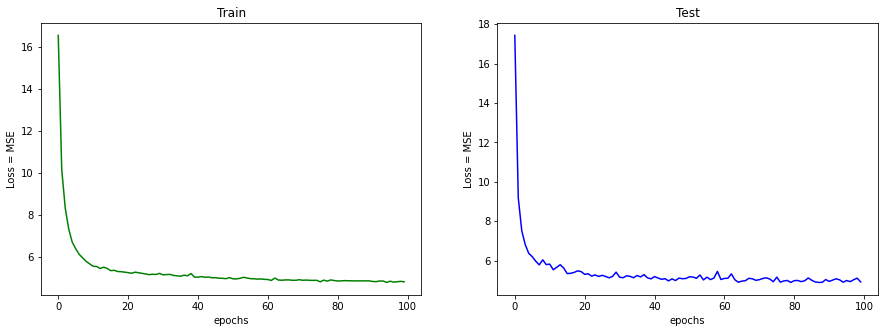

In [22]:
#breakfast hour
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history_nn.history['loss'], color = 'green')
ax[1].plot(history_nn.history['val_loss'], color = 'blue')

ax[0].set_title('Train')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss = MSE')

ax[1].set_title('Test')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss = MSE');

In [23]:
y_nn_pred = model_nn.predict(X_nn_test_sc)

109/109 [==============================] - 0s 867us/step


In [25]:
# taking a peak at R2
np.sqrt(metrics.r2_score(y_nn_test, y_nn_pred))

0.6778834466729438